In this exploratory notebook, 
1. I expriment with different visualization options 
2. and try to determine feature ranking in terms of accuracy in identifying the target 

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [25]:
# def makeFig(df):
#     fig3, ax3 = plt.subplots(3,3)
#     for n, ax in enumerate(ax3.flatten()):
#             ax.set_title(str(df.columns[n + 3]))
# #             ax.df.iloc[:, 11: 11+ncols].hist(bins=6, layout = (1, ncols))
#             sns.swarmplot(data=df, x=df.columns[n + 3], y="AN_Tx", hue="day")
#             ax.set_axis_off()


Load Images and Image Data

In [26]:
# load lung image tissue data using pandas
df = pd.read_excel("image_data_complete_oldMLI.xlsx",index_col = 0)

# Make categorical columns categorical
df['day'] = pd.Categorical(df.day)
# df = df.rename(columns={"AN Tx": "AN_Tx"})
df['AN_Tx'] = pd.Categorical(df.AN_Tx)
df['Ventilation'] = pd.Categorical(df.Ventilation)
df['slide'] = pd.Categorical(df.slide)
df['subslide'] = pd.Categorical(df.subslide)

# check for NA, double check the data type
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 628
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   day                    233 non-null    category
 1   slide                  233 non-null    category
 2   subslide               233 non-null    category
 3   tissue area fraction   233 non-null    float64 
 4   length of tissue (px)  233 non-null    int64   
 5   width of tissue (px)   233 non-null    float64 
 6   number_of_lumens       233 non-null    int64   
 7   R_equiv                233 non-null    float64 
 8   Rmidpoint              233 non-null    float64 
 9   T_tilde                233 non-null    float64 
 10  area of tissue (px^2)  233 non-null    float64 
 11  area of tissue se2     233 non-null    float64 
 12  area of tissue se3     233 non-null    float64 
 13  area of tissue se4     233 non-null    float64 
 14  area of tissue se5     233 non-null    flo

Let's make a histogram of areas left after erosion by structuring elements of radius 2,3, and 4 um

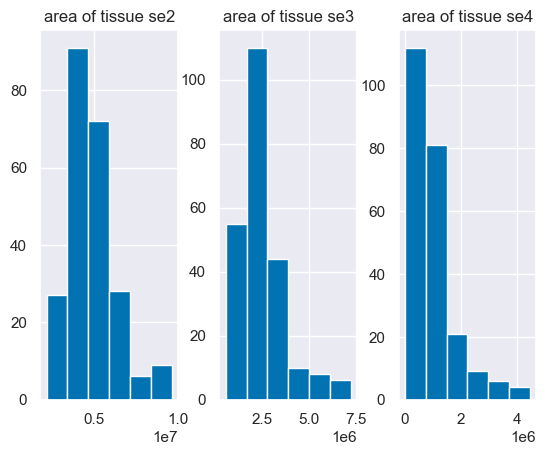

In [27]:
# fig, axes = plt.subplots(ncols=2,nrows=1)

# for n, ax in enumerate(axes.flat):
# for n in range(1,6): 
ncols = 3
hist = df.iloc[:, 11: 11+ncols].hist(bins=6, layout = (1, ncols))
    
    
plt.show()

Separating by day, we see that the day 7 has thinner tissue and we will have more images with zero tissue area left when the structuring element has radius 5 um.

<AxesSubplot: xlabel='area of tissue se5', ylabel='Density'>

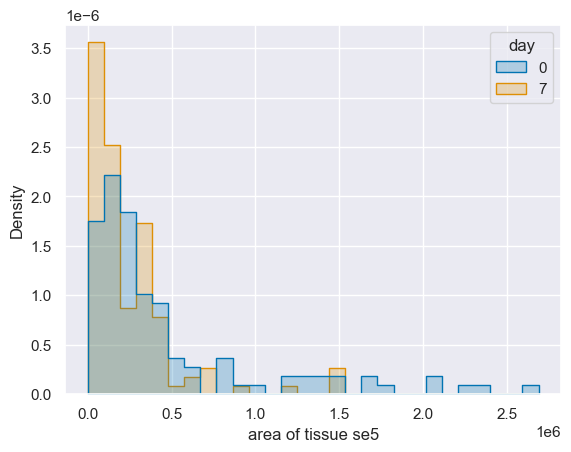

In [28]:
sns.histplot(
    df, x="area of tissue se5", hue="day", element="step",
    stat="density", common_norm=False,
)

# se5 is when the number of zeros in day 7 suddenly surpasses day 0

The swarm plots are also be helpful in showing categorical data:

[Text(31.75, 0.5, '')]

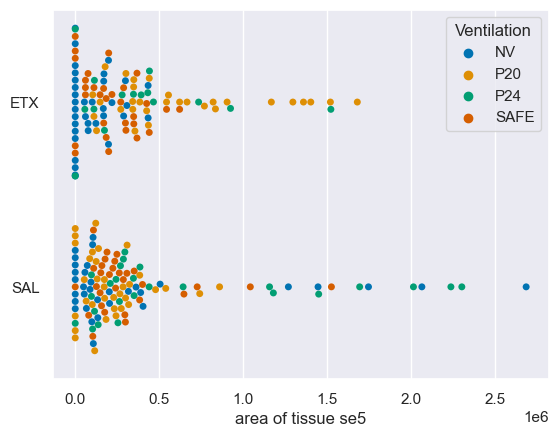

In [29]:
ax = sns.swarmplot(data=df, x="area of tissue se5", y="AN_Tx", hue="Ventilation")
ax.set(ylabel="")

[Text(31.75, 0.5, '')]

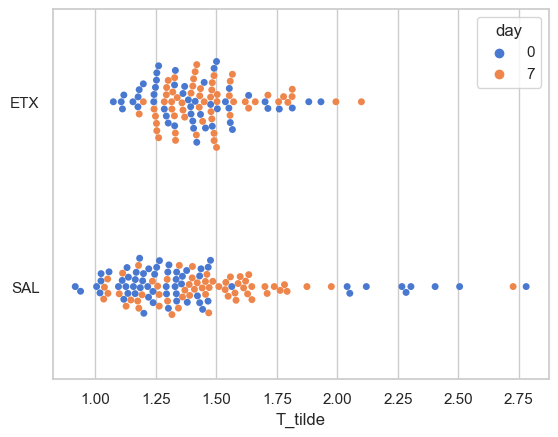

In [30]:
# Draw a categorical scatterplot to show each observation
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df, x="T_tilde", y="AN_Tx", hue="day")
ax.set(ylabel="")

[Text(31.75, 0.5, '')]

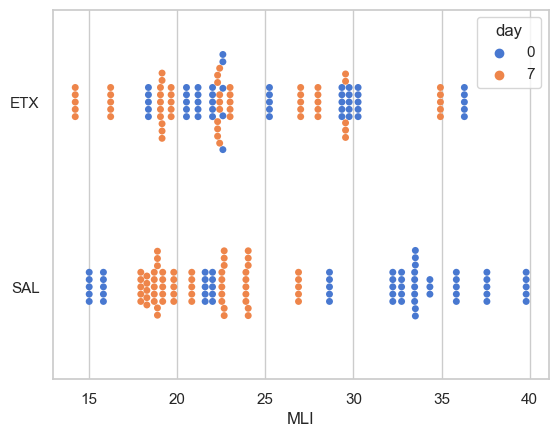

In [31]:
ax = sns.swarmplot(data=df, x="MLI", y="AN_Tx", hue="day")
ax.set(ylabel="")

[Text(31.75, 0.5, '')]

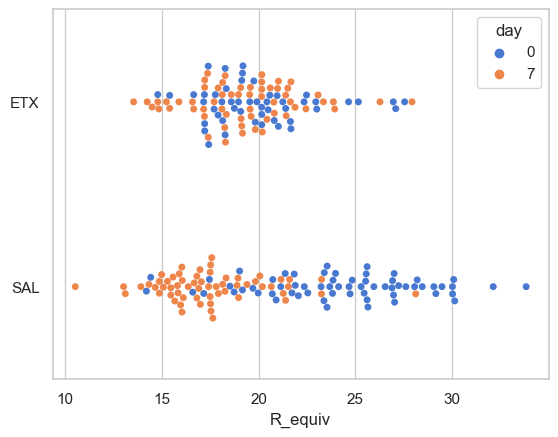

In [33]:
ax = sns.swarmplot(data=df, x="R_equiv", y="AN_Tx", hue="day")
ax.set(ylabel="")

[Text(31.75, 0.5, '')]

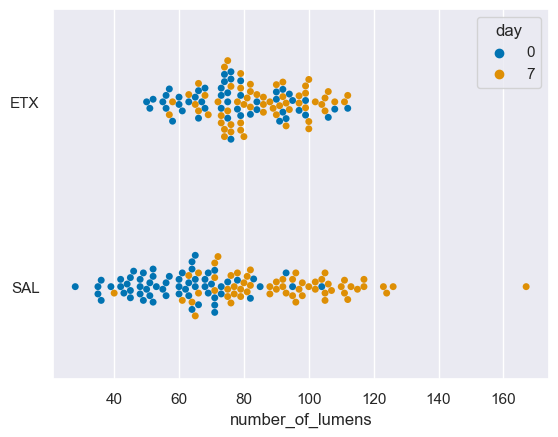

In [34]:
sns.set_theme(palette = 'colorblind')
ax = sns.swarmplot(data=df, x="number_of_lumens", y="AN_Tx", hue="day")
ax.set(ylabel="")

# Feature Importance
Let's switch gears here and try to extract the most important features. To do this, we would need a predictive model, and for our chosen model, we score each feature based on how accurately it predicts the target.

Since we are interested in categorical target data,e.g., treatment or control, we use a classification model instead of regression.

First, we split the data into train and test. I would like to have an evaluation split in the future, but for now let's keep it experimental and simple. 

In [72]:
# assign the treatment label values to y
y = df["AN_Tx"].values

# X = df[["T_tilde", "R_equiv", "MLI", "area of tissue se5"]].values
# choose columns ['tissue area fraction', 'length of tissue (px)', 'width of tissue (px)',
#        'number_of_lumens', 'R_equiv', 'Rmidpoint','T_tilde', 'MLI', 'MLI_edit pics']
X = pd.concat([df.iloc[:,3:10], df.iloc[:,23:25]], axis = 1).values
print(X.shape)
print(X)

(233, 9)
[[3.53572399e-01 4.36450000e+04 1.29777248e+02 ... 1.12600724e+00
  3.22327146e+01 3.21092484e+01]
 [3.05519787e-01 3.75430000e+04 1.30366220e+02 ... 9.16517617e-01
  3.22327146e+01 3.21092484e+01]
 [4.14067369e-01 5.28540000e+04 1.25501192e+02 ... 1.33427427e+00
  3.22327146e+01 3.21092484e+01]
 ...
 [5.80382157e-01 6.38610000e+04 1.45590501e+02 ... 2.09906109e+00
  1.42069676e+01 1.44614265e+01]
 [5.76860620e-01 6.67690000e+04 1.38404664e+02 ... 1.99375791e+00
  1.42069676e+01 1.44614265e+01]
 [5.36179864e-01 6.47350000e+04 1.32686290e+02 ... 1.79524667e+00
  1.42069676e+01 1.44614265e+01]]


In [73]:
cols = ['tissue area fraction', 'length of tissue (px)', 'width of tissue (px)',
       'number_of_lumens', 'R_equiv', 'Rmidpoint','T_tilde', 'MLI', 'MLI_edit pics']

In [74]:
ss = StandardScaler()

dtree = DecisionTreeClassifier()

# split out evaluation sets (x_eval and y_eval)
# x_interim, x_eval, y_interim, y_eval = train_test_split(X,
#                                            y,
#                                            test_size=0.2,
#                                            random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                           random_state=52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# print(x_eval.shape[0], 'eval samples')

x_train shape: (139, 9)
139 train samples
94 test samples


Feature: tissue area fraction Score: 0.12228
Feature: length of tissue (px) Score: 0.04483
Feature: width of tissue (px) Score: 0.12377
Feature: number_of_lumens Score: 0.02802
Feature: R_equiv Score: 0.16856
Feature: Rmidpoint Score: 0.09129
Feature: T_tilde Score: 0.11928
Feature: MLI Score: 0.07380
Feature: MLI_edit pics Score: 0.22817


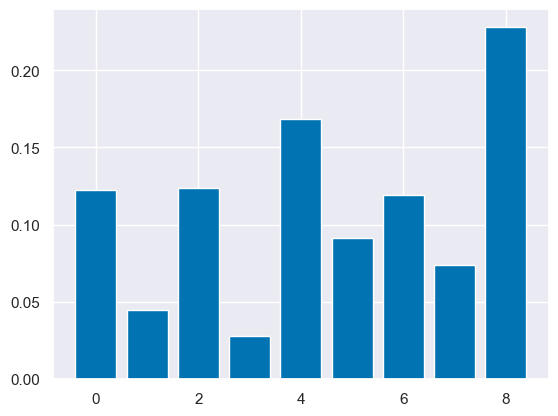

In [75]:
dtree.fit(X,y)
feature_importance = dtree.feature_importances_

# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %s Score: %.5f' % (cols[i],v))
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.show()

(233, 2)
Feature: 0, Score: 0.44075
Feature: 1, Score: 0.55925


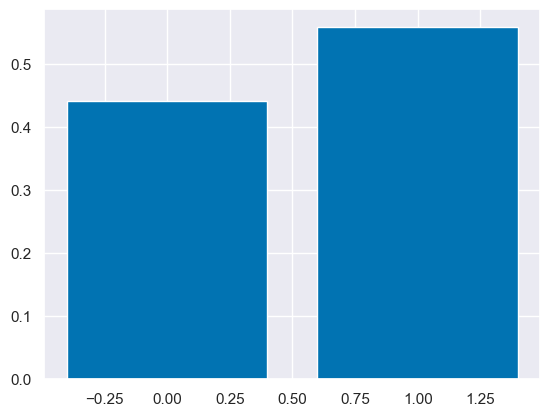

In [76]:
X = df.iloc[:,23:25].values
print(X.shape)
dtree.fit(X,y)
feature_importance = dtree.feature_importances_

# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.show()

In [77]:
# model.fit(
#     x_train,
#     y_train,
#     validation_data=(x_test, y_test)
# )

Well, that was kind of disappointing..but very interesting. So MLI_edit performs more than x2 better than MLI. Now, let's try a forest classifier instead:

Feature: 0, Score: 0.46606
Feature: 1, Score: 0.53394


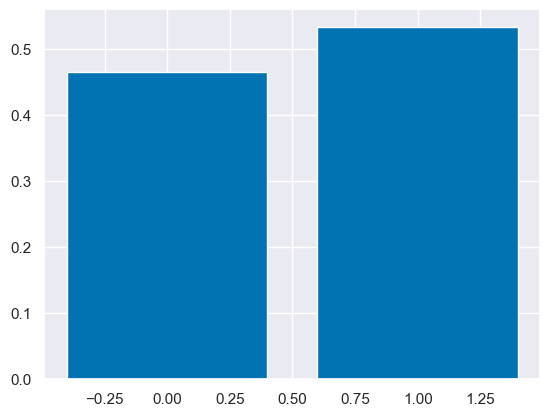

In [78]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier()

rforest.fit(X,y)

ft_importance = rforest.feature_importances_
# summarize feature importance
for i,v in enumerate(ft_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(ft_importance))], ft_importance)
plt.show()

Okay, this seems more reasonable. MLI_edit only performs slightly better than MLI. Let's try the rest of the measures:

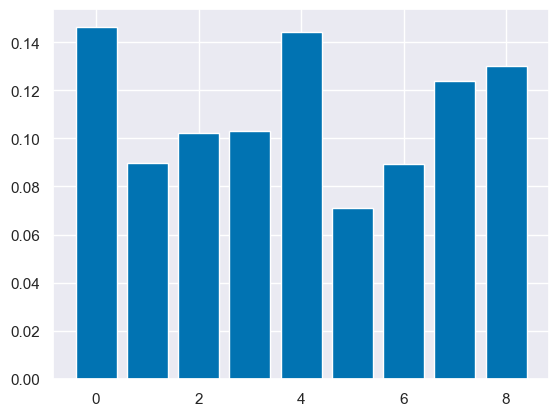

In [79]:
X = pd.concat([df.iloc[:,3:10], df.iloc[:,23:25]], axis = 1).values
rforest.fit(X,y)

ft_importance = rforest.feature_importances_
# plot feature importance
plt.bar([x for x in range(len(ft_importance))], ft_importance)
plt.show()
